### Calculate K-Means clustering statistics to show the latent space is grouping by size and shape of LNs and by clinical data

In [50]:
#pip install classixclustering

import torch
import numpy as np
import pandas as pd
import os
import sys
import pickle
from time import perf_counter
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from classix import CLASSIX
import nibabel as nib
#from pytorch_msssim import ssim
import nibabel as nib
from itertools import combinations
from skimage.metrics import structural_similarity as ssim

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.datasets import Load_Latent_Vectors, LoadImages, prepare_VAE_MLP_joint_data
from utils.utility_code import get_single_scan_file_list


### Load the latent vectors and data 
### Save LN size / shape / clinical data to a data table

In [ ]:
IMAGE_DIR = r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1_2D_slices"
# IMAGE_DIR = r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\2d_slices"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cohort1 = pd.read_excel(r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1.xlsx")
latent_vectors = np.load(r"C:\Users\mm17b2k.DS\Documents\Python\ARCANE_Results\VAE_MLP_cross_validation\latent_vectors_fold_0_run_5.npy")
#latent_vectors = np.load(r"C:\Users\mm17b2k.DS\Documents\Python\ARCANE_Results\VAE2_results\latent_vectors_36.npy")

all_files_list = ['\mri' + '//' + f for f in os.listdir(IMAGE_DIR + '\mri')] + ['\mri_aug' + '//' + f  for f in os.listdir(IMAGE_DIR + '\mri_aug')]
all_files_list.sort()
all_files_list = get_single_scan_file_list(all_files_list, IMAGE_DIR, cohort1)


#VAE_params_path = r"C:\Users\mm17b2k.DS\Documents\Python\ARCANE_Results\VAE2_results\VAE_36.pt"
VAE_params_path = r"C:\Users\mm17b2k.DS\Documents\Python\ARCANE_Results\VAE_MLP_cross_validation\VAE_fold_0_run_5_ssim_0.727695107460022.pt"
checkpoint = torch.load(VAE_params_path)
train_test_split_dict = checkpoint['train_test_split']
train_ids = train_test_split_dict['train']
test_ids = train_test_split_dict['test']
clinical_data_options = []
max_node_slices = 25
n_synthetic = 0
oversample = 1

first_time = False
if first_time:
    patient_slices_dict, patient_labels_dict, patient_file_names_dict, short_long_axes_dict, mlp_train_ids, test_ids, mlp_train_labels, test_labels, train_images, test_images, train_test_split_dict, mask_sizes = prepare_VAE_MLP_joint_data(first_time_train_test_split=False, train_ids=train_ids, test_ids=test_ids, num_synthetic=n_synthetic, oversample_ratio=oversample)

    with open(r"C:\Users\mm17b2k.DS\Documents\Python\ARCANE_Results\patient_slices_dict.pkl", 'wb') as f:
        pickle.dump(patient_slices_dict, f)
    with open(r"C:\Users\mm17b2k.DS\Documents\Python\ARCANE_Results\patient_labels_dict.pkl", 'wb') as f:
        pickle.dump(patient_labels_dict, f)
    with open(r"C:\Users\mm17b2k.DS\Documents\Python\ARCANE_Results\short_long_axes_dict.pkl", 'wb') as f:
        pickle.dump(short_long_axes_dict, f)
        
        
else:
    with open(r"C:\Users\mm17b2k.DS\Documents\Python\ARCANE_Results\patient_slices_dict.pkl", 'rb') as f:
        patient_slices_dict = pickle.load(f)
    with open(r"C:\Users\mm17b2k.DS\Documents\Python\ARCANE_Results\patient_labels_dict.pkl", 'rb') as f:
        patient_labels_dict = pickle.load(f)
    with open(r"C:\Users\mm17b2k.DS\Documents\Python\ARCANE_Results\short_long_axes_dict.pkl", 'rb') as f:
        short_long_axes_dict = pickle.load(f)

patient_ids = train_ids + test_ids
print("number of patients", len(patient_ids))

labels = np.array([patient_labels_dict[patient_id] for patient_id in patient_ids])
print("proportion of benign", len(np.where(labels == 0)[0])/len(labels)*100)
print("proportion of malignant", len(np.where(1 == labels)[0])/len(labels)*100)



metadata = {}

with open(r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\border_metrics.pkl", 'rb') as f:
    compactness_dict, convexity_dict = pickle.load(f)

#get all key values from patient_slices_dict
all_slice_indices = []
patient_ids = []
files = []
for key in patient_slices_dict:
    all_slice_indices += patient_slices_dict[key]
    patient_ids += [key]*len(patient_slices_dict[key])
    files += [all_files_list[i] for i in patient_slices_dict[key]]

# resave latent vectors with just indices in all_slice_indices
latent_vectors = latent_vectors[all_slice_indices]
print(latent_vectors.shape)
print("number of slices", len(all_slice_indices))

unique_pat_ids = []
pat_id_index = -1
for i, slice in enumerate(all_slice_indices):
    if patient_ids[i] not in unique_pat_ids:
        pat_id_index += 1
        unique_pat_ids.append(patient_ids[i])
    node = int(files[i].split("\\")[-1].split("_")[-2])

    norm_long = short_long_axes_dict[patient_ids[i]][float(node)][0]
    norm_short = short_long_axes_dict[patient_ids[i]][float(node)][1]
    norm_ratio = short_long_axes_dict[patient_ids[i]][float(node)][2]
    min_S, max_S = np.round(1.6206887424795668, 3), np.round(14.787397134046275, 3)
    min_L, max_L = np.round(3.6764972460210004, 3), np.round(19.82188472370879, 3)
    min_R, max_R = 0, np.round(0.8109811286010666, 3)
    
    long = norm_long * (max_L - min_L) + min_L
    short = norm_short * (max_S - min_S) + min_S
    ratio = norm_ratio * (max_R - min_R) + min_R
    
    age = cohort1.loc[cohort1['shortpatpseudoid'] == patient_ids[i]]['jitteredageatprimarydiagnosis'].to_list()[0]
    sex = cohort1.loc[cohort1['shortpatpseudoid'] == patient_ids[i]]['sex'].to_list()[0]
    T = cohort1.loc[cohort1['shortpatpseudoid'] == patient_ids[i]]['TumourLabel'].to_list()[0]
    N = cohort1.loc[cohort1['shortpatpseudoid'] == patient_ids[i]]['NodeLabel'].to_list()[0]
    M = cohort1.loc[cohort1['shortpatpseudoid'] == patient_ids[i]]['MetastasisLabel'].to_list()[0]

    file = files[i]
    mask_file = file.replace('mri', 'mask')
    compactness = compactness_dict[mask_file]
    convexity = convexity_dict[mask_file]
    
    metadata[i] = {"index": slice, "patient_id": patient_ids[i], "patient_index" : pat_id_index,
                   "label": patient_labels_dict[patient_ids[i]], "file": files[i],
                   "node": node,
                   "slice": files[i].split("\\")[-1].split("_")[-1].split(".")[0],
                   "long_axis": long,
                   "short_axis": short,
                   "ratio": ratio,
                   "age": age,
                   "sex": sex,
                   "T": T,
                   "N": N,
                   "M": M,
                   "compactness": compactness,
                   "convexity": convexity
                   
                   }

df = pd.DataFrame.from_dict(metadata, orient='index')
df = df.reset_index(drop=False)
df = df.rename(columns={"level_0": "slice_index"})
labels = list(df['label'].values)
# save df
df.to_csv(r"C:\Users\mm17b2k.DS\Documents\Python\ARCANE_Results\LN_df.csv")
df

# number of patients 168
# proportion of benign 77.38095238095238
# proportion of malignant 22.61904761904762
# (1317, 384)
# number of slices 1317

### Elbow and Silhouette Score to judge optimal range of cluster size

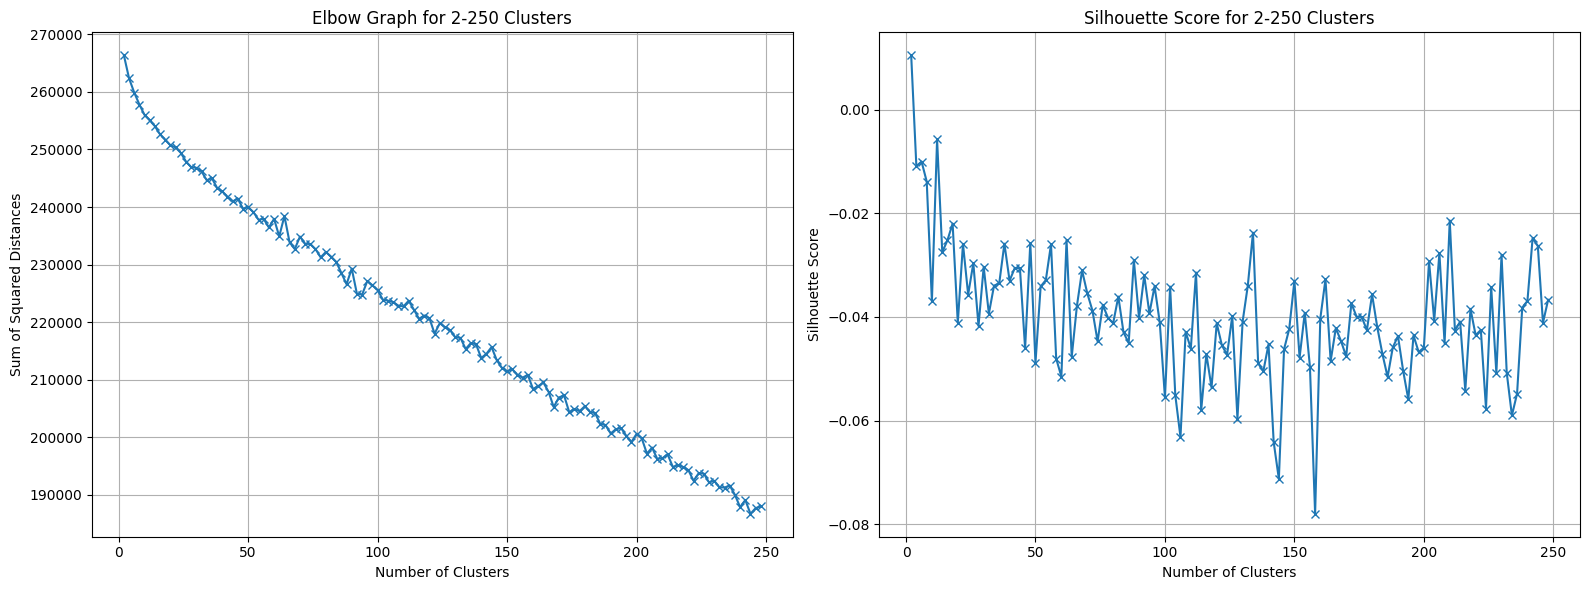

In [23]:
distortions = []
sillhouettes = []
for k in range(2,250,2):
    k_means = KMeans(n_clusters = k, n_init=10)
    k_means.fit(latent_vectors)
    cluster_labels = k_means.fit_predict(latent_vectors)  # Use fit_predict to get the cluster labels
    silhouette_avg = silhouette_score(latent_vectors, cluster_labels)  # Calculate silhouette score
    distortions.append(round(k_means.inertia_))
    sillhouettes.append(silhouette_avg)


fig, ax = plt.subplots(1, 2, figsize=(16, 6)) 
# Plot the Elbow graph
ax[0].plot(range(2, 250, 2), distortions, marker='x')
ax[0].grid(True)
ax[0].set_ylabel('Sum of Squared Distances')
ax[0].set_xlabel('Number of Clusters')
ax[0].set_title('Elbow Graph for 2-250 Clusters')
# Plot the Silhouette Score graph
ax[1].plot(range(2, 250, 2), sillhouettes, marker='x')
ax[1].grid(True)
ax[1].set_ylabel('Silhouette Score')
ax[1].set_xlabel('Number of Clusters')
ax[1].set_title('Silhouette Score for 2-250 Clusters')
plt.tight_layout()
plt.show()

### Functions to calculate cluster statistics and display results

In [53]:
import numpy as np

def calculate_cluster_statistics(cluster_dict, df, verbose=True):
    # Initialize dictionaries to store counts per cluster for each variable
    sex_counts = {"Male": [], "Female": []}
    T_counts = {'1': [], '2': [], '3+': []}
    N_counts = {'0': [], '1+': [], '1': [], '2+': []}
    M_counts = {'0': [], '1': [], 'X': []}
    age_averages = []
    border_irregularity_counts1 = []  
    border_irregularity_std1 = []
    border_irregularity_counts2 = []  
    border_irregularity_std2 = []
    ratio_means = []
    radio_stds = []
    ratio_counts = {"0-0.25": [], "0.25-0.5": [], "0.5-1.0": []}
    short_means = []
    short_stds = []
    short_counts = {"0-5": [], "5-8": [], "8+": [], "5+": []}
    long_stds = []
    long_means = []
    short_ranges = []
    long_ranges = []
    ratio_ranges = []
    BI_ranges = []

    for cluster_label, slice_ids in cluster_dict.items():
        # Filter the DataFrame to include only rows in the current cluster
        cluster_df = df[df['slice_index'].isin(slice_ids)]

        # Proportions for 'sex'
        male_count = (cluster_df['sex'] == "Male").sum()
        female_count = (cluster_df['sex'] == "Female").sum()
        total_count = male_count + female_count
        sex_counts["Male"].append(male_count / total_count if total_count > 0 else 0)
        sex_counts["Female"].append(female_count / total_count if total_count > 0 else 0)

        # Proportions for 'T', 'N', 'M'
        T_counts['1'].append((cluster_df['T'] == '1').sum() / len(cluster_df))
        T_counts['2'].append((cluster_df['T'] == '2').sum() / len(cluster_df))
        T_counts['3+'].append(((cluster_df['T'] == '3').sum() +
                               (cluster_df['T'] == '3a').sum() +
                               (cluster_df['T'] == '4').sum() +
                               (cluster_df['T'] == '4b').sum()) / len(cluster_df))
        N_counts['0'].append((cluster_df['N'] == '0').sum() / len(cluster_df))
        N_counts['1+'].append(((cluster_df['N'] == '1').sum() +
                               (cluster_df['N'] == '1a').sum() +
                               (cluster_df['N'] == '1b').sum() +
                               (cluster_df['N'] == '2').sum() +
                               (cluster_df['N'] == '2a').sum() +
                               (cluster_df['N'] == '2b').sum()) / len(cluster_df))
        N_counts['1'].append(((cluster_df['N'] == '1').sum() +
                              (cluster_df['N'] == '1a').sum() +
                              (cluster_df['N'] == '1b').sum()) / len(cluster_df))
        N_counts['2+'].append(((cluster_df['N'] == '2').sum() +
                               (cluster_df['N'] == '2a').sum() +
                               (cluster_df['N'] == '2b').sum()) / len(cluster_df))

        M_counts['0'].append((cluster_df['M'] == '0').sum() / len(cluster_df))
        M_counts['1'].append((cluster_df['M'] == '1').sum() / len(cluster_df))
        M_counts['X'].append(((cluster_df['M'] == 'X').sum() +
                              (cluster_df['M'] == '-').sum()) / len(cluster_df))

        # Average age in the cluster
        age_averages.append(cluster_df['age'].mean())

        # Calculate border irregularity if available
        border_irregularity_counts1.append(cluster_df['compactness'].mean())
        border_irregularity_counts2.append(cluster_df['convexity'].mean())
        border_irregularity_std1.append(cluster_df['compactness'].std())
        border_irregularity_std2.append(cluster_df['convexity'].std())
                                           
        # Calculate ratio if available
        ratio_mean = cluster_df['ratio'].mean()  # Calculate mean of the 'ratio' column
        ratio_means.append(ratio_mean)
        radio_stds.append(cluster_df['ratio'].std())
        

        # Count the ratios in specified bins
        ratio_0_25 = ((cluster_df['ratio'] >= 0) & (cluster_df['ratio'] <= 0.25)).sum()
        ratio_0_50 = ((cluster_df['ratio'] > 0.25) & (cluster_df['ratio'] <= 0.5)).sum()
        ratio_0_80 = ((cluster_df['ratio'] > 0.5) & (cluster_df['ratio'] <= 1.0)).sum()

        # Append proportions to the ratio_counts
        total_ratios = len(cluster_df['ratio'])
        ratio_counts["0-0.25"].append(ratio_0_25 / total_ratios if total_ratios > 0 else 0)
        ratio_counts["0.25-0.5"].append(ratio_0_50 / total_ratios if total_ratios > 0 else 0)
        ratio_counts["0.5-1.0"].append(ratio_0_80 / total_ratios if total_ratios > 0 else 0)
        
        # Calculate short axis if available
        short_mean = short_means.append(cluster_df['short_axis'].mean()) 
        short_stds.append(cluster_df['short_axis'].std())
        long_stds.append(cluster_df['long_axis'].std())
        long_means.append(cluster_df['long_axis'].mean())
        # Count the short axes in specified bins
        short_0_5 = ((cluster_df['short_axis'] >= 0) & (cluster_df['short_axis'] <= 5)).sum()
        short_5_8 = ((cluster_df['short_axis'] > 5) & (cluster_df['short_axis'] <= 8)).sum()
        short_8_plus = (cluster_df['short_axis'] > 8).sum()
        short_5_plus = (cluster_df['short_axis'] > 5).sum()
        
        # Append proportions to the short_counts
        total_shorts = len(cluster_df['short_axis'])
        short_counts["0-5"].append(short_0_5 / total_shorts if total_shorts > 0 else 0)
        short_counts["5-8"].append(short_5_8 / total_shorts if total_shorts > 0 else 0)
        short_counts["8+"].append(short_8_plus / total_shorts if total_shorts > 0 else 0)
        short_counts["5+"].append(short_5_plus / total_shorts if total_shorts > 0 else 0)
        
        short_ranges.append(cluster_df['short_axis'].max() - cluster_df['short_axis'].min())
        long_ranges.append(cluster_df['long_axis'].max() - cluster_df['long_axis'].min())
        ratio_ranges.append(cluster_df['ratio'].max() - cluster_df['ratio'].min())
        BI_ranges.append(0.5*((cluster_df['compactness'].max() - cluster_df['compactness'].min()) + 0.5*(cluster_df['convexity'].max() - cluster_df['convexity'].min())))
        
        

    if verbose == True:
        # Output the results
        print("Sex Proportions:")
        male_min = min(sex_counts['Male'])
        male_max = max(sex_counts['Male'])
        male_mean = np.mean(sex_counts['Male'])
        male_std = np.std(sex_counts['Male'])
        print(f"  Male: Min={male_min:.2f}, Max={male_max:.2f}, Mean={male_mean:.2f}, Std Dev={male_std:.2f}")
        
        female_min = min(sex_counts['Female'])
        female_max = max(sex_counts['Female'])
        female_mean = np.mean(sex_counts['Female'])
        female_std = np.std(sex_counts['Female'])
        print(f"  Female: Min={female_min:.2f}, Max={female_max:.2f}, Mean={female_mean:.2f}, Std Dev={female_std:.2f}")
        
        print("\nT Proportions Statistics:")
        for T_val, proportions in T_counts.items():
            print(f"  T={T_val}: Min={min(proportions):.2f}, Max={max(proportions):.2f}, Mean={np.mean(proportions):.2f}, Median={np.median(proportions):.2f}, Std Dev={np.std(proportions):.2f}, IQR={np.percentile(proportions, 75) - np.percentile(proportions, 25):.2f}")
            print('cluster number with min and max', T_val, T_counts[T_val].index(min(T_counts[T_val])), T_counts[T_val].index(max(T_counts[T_val])))
        
        print("\nN Proportions Statistics:")
        for N_val, proportions in N_counts.items():
            print(f"  N={N_val}: Min={min(proportions):.2f}, Max={max(proportions):.2f}, Mean={np.mean(proportions):.2f}, Median={np.median(proportions):.2f}, Std Dev={np.std(proportions):.2f}, IQR={np.percentile(proportions, 75) - np.percentile(proportions, 25):.2f}")
            print('cluster number with min and max', N_val, N_counts[N_val].index(min(N_counts[N_val])), N_counts[N_val].index(max(N_counts[N_val])))
        
        print("\nM Proportions Statistics:")
        for M_val, proportions in M_counts.items():
            print(f"  M={M_val}: Min={min(proportions):.2f}, Max={max(proportions):.2f}, Mean={np.mean(proportions):.2f}, Std Dev={np.std(proportions):.2f}")
        
        print("\nAverage Age in each Cluster:")
        print(f"  Min Age={min(age_averages):.2f}, Max Age={max(age_averages):.2f}, Mean Age={np.mean(age_averages):.2f}, Std Dev Age={np.std(age_averages):.2f}")
        
        print("\nBorder Irregularity Statistics:")
        for i, counts in enumerate([border_irregularity_counts1, border_irregularity_counts2], start=1):
            print(f"  Border Irregularity {i}: Mean={np.mean(counts):.2f}, Median={np.median(counts):.2f}, Min={min(counts):.2f}, Max={max(counts):.2f}, Std Dev={np.std(counts):.2f}, IQR={np.percentile(counts, 75) - np.percentile(counts, 25):.2f}, Compactness inter-cluster Std Dev={np.mean(border_irregularity_std1):.2f}", f"Convexity inter-cluster Std Dev={np.mean(border_irregularity_std2):.2f}")
            print('min BI', 0.5*(np.min(border_irregularity_std1)+np.min(border_irregularity_std2)), 'Max BI', 0.5*(np.max(border_irregularity_std1)+np.max(border_irregularity_std2)))
            
        print("\nRatio Statistics:")
        print(f"  Mean Ratio={np.mean(ratio_means):.2f}, Median Ratio={np.median(ratio_means):.2f}, Std Dev Ratio={np.std(ratio_means):.2f}, inter cluster std dev={np.mean(radio_stds):.2f}")
        for range_label, proportions in ratio_counts.items():
            print(f"  {range_label}: Min={min(proportions):.2f}, Max={max(proportions):.2f}, Mean={np.mean(proportions):.2f}, Std Dev={np.std(proportions):.2f}")
            print('cluster number with min and max', range_label, proportions.index(min(proportions)), proportions.index(max(proportions)))
    
        print("\nShort Axis Statistics:")
        print(f"  Mean Short Axis={np.mean(short_means):.2f}, Median Short Axis={np.median(short_means):.2f}, Std Dev Short Axis={np.std(short_means):.2f}, inter cluster std dev={np.mean(short_stds):.2f}")
        for range_label, proportions in short_counts.items():
            # remove 0s from proportions
            proportions = [prop for prop in proportions if prop != 0]
            print(f"  {range_label}: Min={min(proportions):.2f}, Max={max(proportions):.2f}, Mean={np.mean(proportions):.2f}, Std Dev={np.std(proportions):.2f}")
            print('cluster number with min and max', range_label, proportions.index(min(proportions)), proportions.index(max(proportions)))
            
        print("\nLong Axis Statistics:")
        print(f"  Mean Long Axis={np.mean(long_means):.2f}, Median Long Axis={np.median(long_means):.2f}, Std Dev Long Axis={np.std(long_means):.2f}, inter cluster std dev={np.mean(long_stds):.2f}")
        
    
    return np.mean(short_stds), np.mean(long_stds), np.mean(radio_stds), 0.5*(np.mean(border_irregularity_std1)+np.mean(border_irregularity_std2)), np.min(short_stds), np.max(short_stds), np.min(long_stds), np.max(long_stds), np.min(radio_stds), np.max(radio_stds), 0.5*(np.min(border_irregularity_std1)+np.min(border_irregularity_std2)), 0.5*(np.max(border_irregularity_std1)+np.max(border_irregularity_std2)), [np.min(short_ranges), np.min(long_ranges), np.min(ratio_ranges), np.min(BI_ranges)], [np.max(short_ranges) , np.max(long_ranges), np.max(ratio_ranges), np.max(BI_ranges)],  [np.mean(short_ranges), np.mean(long_ranges), np.mean(ratio_ranges), np.mean(BI_ranges)],




def calculate_average_ssim(cluster_dict, df, verbose=True):
    """
    Calculate the average SSIM between every combination of images in the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing image file names.
        file_column (str): The column name in the DataFrame that contains the image file names.
        verbose (bool): Whether to print the SSIM statistics.

    Returns:
        float: The average SSIM across all combinations.
    """
    total_ssims = []
    for cluster_label, slice_ids in cluster_dict.items():

        cluster_df = df[df['slice_index'].isin(slice_ids)]
        ssim_values = []
        file_list = cluster_df['file'].values
        file_root = r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1_2D_slices"
    
        # Load all images
        images = []
        for file_name in file_list:
            # Load .nii file and extract the image data
            img = nib.load(file_root + file_name).get_fdata()
            # Normalize the image to [0, 1] and convert to torch tensor
            img = (img - img.min()) / (img.max() - img.min())
            img = np.squeeze(img)
            images.append(img)
    
        # Calculate SSIM for each pair of images
        for (img1, img2) in combinations(images, 2):
            ssim_score = ssim(img1, img2, data_range=img1.max() - img1.min())
            ssim_values.append(ssim_score.item())  # Extract the float value
    
        # Compute average SSIM
        cluster_average_ssim = sum(ssim_values) / len(ssim_values) if ssim_values else 0.0
        total_ssims.append(cluster_average_ssim)
    
 
        #print(f"Average SSIM: {cluster_average_ssim:.4f}")
        
    average_ssim = sum(total_ssims) / len(total_ssims) if total_ssims else 0.0
    print(f"Average inter-cluster SSIM across all clusters: {average_ssim:.4f}")
    print('min', np.min(total_ssims), 'max', np.max(total_ssims))
    return average_ssim


def view_img(files, display_size, filename):
    IMAGE_DIR = r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1_2D_slices"
    SAVE_DIR = r"C:\Users\mm17b2k.DS\Documents\Python\ARCANE_Results\Clustering_Results"

    plt.figure(figsize=(10, 10))

    for i, image in enumerate(files):
        plt.subplot(display_size, display_size, i + 1)
        img = nib.load(IMAGE_DIR + "//" + image)
        img_data = img.get_fdata()
        plt.axis('off')
        plt.imshow(img_data, cmap='gray')

    # Save the figure
    plt.savefig(os.path.join(SAVE_DIR, filename), transparent=True)
    plt.show()
    plt.close()
    print(files)


def get_unchosen_index(cluster_num,index_list, dict):
    already_used_patients = []
    for patient in index_list:
        already_used_patients.append(patient_ids[patient])

    x = random.choice(list(kmeans_dict.keys()))

    i = 0
    while patient_ids[x] in already_used_patients:
        i+=1
        if i == 100:
            return x
        x = random.choice(list(kmeans_dict.keys()))


    return x

def cluster_sizes(dict):
    cluster_sizes = []
    for key in dict:
        cluster_sizes.append(len(dict[key]))
    sorted_sizes = sorted(cluster_sizes)
    print("Number of Clusters", len(sorted_sizes)) #, "Top 10 Clusters", sorted_sizes[-10:], "Lowest 10", sorted_sizes[:10])

def print_random_cluster_sample(cluster_dict, name, proportions, df):
    """
    Print random sample images from clusters with highest benign and malignant proportions 
    and a few random clusters.
    
    Parameters:
    cluster_dict (dict): A dictionary mapping cluster labels to slice IDs.
    name (str): A string used for naming output files.
    proportions (list): A list of malignant proportions for each cluster.
    df (DataFrame): A DataFrame containing image file paths ('file' column).
    """

    # Get the list of file paths from the DataFrame
    all_files_list = list(df['file'].values)

    # Find the indices of clusters with the most benign and most malignant proportions
    benign_cluster_index = proportions.index(min(proportions))
    malignant_cluster_index = proportions.index(max(proportions))

    print(f"Benign cluster index: {benign_cluster_index}, Malignant cluster index: {malignant_cluster_index}")

    # List of selected cluster indices
    clusters = [benign_cluster_index, malignant_cluster_index]

    # Randomly select 3 more clusters that are not already chosen
    while len(clusters) < 10:
        cluster_choice = random.choice(list(range(len(cluster_dict))))
        if cluster_choice not in clusters:
            clusters.append(cluster_choice)

    print("Chosen cluster indices:", clusters)

    # Initialize lists to hold indices for the image samples from each cluster
    index_lists = [[] for _ in range(10)]  # List of 5 lists (one for each cluster)

    # Populate index lists with 9 unchosen indices from each cluster
    for j in range(9):
        for i in range(10):
            index_lists[i].append(get_unchosen_index(clusters[i], index_lists[i], cluster_dict))

    # Create lists of file paths for each cluster based on the selected indices
    files_lists = [[] for _ in range(10)]
    for i, file_path in enumerate(all_files_list):
        for idx, index_list in enumerate(index_lists):
            if i in index_list:
                files_lists[idx].append(file_path)

    # Display and save images for each cluster
    for i in range(10):
        if i == 0:
            print("Most Benign Cluster")
            view_img(files_lists[i], 3, f"{name}_Benign.png")
        elif i == 1:
            print("Most Malignant Cluster")
            view_img(files_lists[i], 3, f"{name}_Malignant.png")
        else:
            print(f"Example from Random Cluster {i}")
            view_img(files_lists[i], 3, f"{name}_example{i}.png")


def patient_proportions(cluster_dict, df):
    """
    Calculate the proportions of patients based on their clustering results.

    Parameters:
    cluster_dict (dict): A dictionary mapping cluster labels to slice IDs.
    df (DataFrame): A DataFrame containing 'label', 'index', and 'patient_index' columns.
    """

    # Extract relevant data from the DataFrame
    labels = df['label'].values 
    slice_indices = df['slice_index'].values 
    patient_id_slices = df['patient_index'].values 

    # Initialize counts
    one_cluster_count = 0
    over_50_percent_count = 0
    over_50_in_2clusters_count = 0
    over_25_percent_count = 0

    # Initialize a list to hold the cluster information for each patient
    patient_cluster_info = {}

    # Collect cluster data for each patient
    for slice_index, patient_id in zip(slice_indices, patient_id_slices):
        if patient_id not in patient_cluster_info:
            patient_cluster_info[patient_id] = []
        # Append the cluster label (1 or 0) corresponding to the current slice index
        for key, cluster_patients in cluster_dict.items():
            if slice_index in cluster_patients:
                patient_cluster_info[patient_id].append(key)
                
    print(patient_cluster_info)

    # Analyze the clusters
    for locs in patient_cluster_info.values():
        num_unique_clusters = len(np.unique(locs))

        # Count occurrences of each cluster for the current patient
        locs_counts = np.bincount(locs)
        # Count patients in various clustering scenarios
        if num_unique_clusters == 1:
            one_cluster_count += 1
        if max(locs_counts) > 0.5 * len(locs):
            over_50_percent_count += 1
        if max(locs_counts) > 0.25 * len(locs):
            over_25_percent_count += 1
        if num_unique_clusters > 2:
            if (max(locs_counts) + np.partition(locs_counts, -2)[-2]) > 0.5 * len(locs):
                over_50_in_2clusters_count += 1

    total_patients = 168

    # Print the results
    print(f"{one_cluster_count} patients are in only 1 cluster (proportion: {one_cluster_count/total_patients:.2f})")
    print(f"{over_50_percent_count} patients are at least 50% in 1 cluster (proportion: {over_50_percent_count/total_patients:.2f})")
    print(f"{over_25_percent_count} patients are at least 25% in 1 cluster (proportion: {over_25_percent_count/total_patients:.2f})")
    print(f"{over_50_in_2clusters_count} patients are at least 50% across 2 clusters (proportion: {over_50_in_2clusters_count/total_patients:.2f})")

    return (
        one_cluster_count / total_patients,
        over_50_percent_count / total_patients,
        over_25_percent_count / total_patients
    )


def plot_cluster_distribution(dict):
    keys = list(dict.keys())
    values = [len(v) for v in dict.values()]

    # Plot the bar chart
    x = range(len(keys))
    plt.bar(x, values)

    # Add labels to the x-axis
    plt.xticks(x, keys)
    # Show the plot
    plt.show()
    
# Get proportion of malignant in each cluster
def get_malignant_proportions(cluster_dict, df, verbose=0):
    """
    Calculate the proportion of malignant cases in each cluster.
    
    Parameters:
    cluster_dict (dict): A dictionary mapping cluster labels to slice IDs.
    df (DataFrame): A DataFrame containing 'label' and 'slice_index' columns.
    verbose (int): Set to 1 for detailed output, 0 for minimal output.
    
    Returns:
    proportions (list): A list of malignant proportions for each cluster.
    """

    # Extract the 'label' column from the DataFrame (0 for benign, 1 for malignant)
    labels = df['label'].values

    # List to store malignant proportions for each cluster
    proportions = []

    for key in cluster_dict:
        num_cancer = 0
        total_cases = len(cluster_dict[key])  # Total number of cases in the cluster

        # Count the number of malignant cases in the current cluster
        for item in cluster_dict[key]:
            num_cancer += labels[item]  # Add 1 if malignant (label is 1)

        # Calculate the proportion of malignant cases in the cluster
        if total_cases > 0:
            proportion_malignant = num_cancer / total_cases
            proportions.append(proportion_malignant)

    # Optionally, print the top 10 clusters with highest and lowest malignant proportions
    if verbose == 1:
        sorted_proportions = sorted(proportions)
        print("Top 10 Most Malignant Proportions:", sorted_proportions[-10:])
        print("Top 10 Most Benign Proportions:", sorted_proportions[:10])

    return proportions


def malignancy_proportion_stats(proportions):
    #sorted_proportions = sorted(proportions)
    #print("Top 10 Malignant", sorted_proportions[:10], "Top 10 Benign", sorted_proportions[-10:])
    low_high1 = 0
    for prop in proportions:
        if prop < 0.33 or prop > 0.67:
            low_high1 +=1
    print("66.6% of one class", low_high1, "Proportion", low_high1/len(proportions))

    low_high2 = 0
    for prop in proportions:
        if prop < 0.25 or prop > 0.75:
            low_high2 +=1
    print("75% of one class", low_high2, "Proportion", low_high2/len(proportions))
    return low_high2/len(proportions), low_high1/len(proportions)

def CLASSIX_Grid_Search(data, df, num_trials, radius_min, radius_max):
    radius = np.linspace(radius_min, radius_max, num_trials)
    metric_list = []
    num_clusters_list = []
    for i in range(len(radius)):
        print("radius", radius[i])
        clx_mus = CLASSIX(radius=radius[i], verbose=0, minPts=10)
        clx_mus.fit(data)
        classix_dict = {i: np.where(clx_mus.labels_ == i)[0] for i in range(len(np.unique(clx_mus.labels_)))}
        print("top cluster sizes", len(classix_dict[0]), len(classix_dict[1]), len(classix_dict[2]))
        num_clusters_list.append(len(classix_dict.keys()))
        print("number of clusters", len(classix_dict.keys()))
        proportions = get_malignant_proportions(classix_dict,df,0)
        mal_prop = malignancy_proportion_stats(proportions)
        metric_list.append(mal_prop)
    best_radius = max(metric_list)
    idx = metric_list.index(best_radius)
    print("best split:", best_radius, "radius:", radius[idx], "number of clusters:", num_clusters_list[idx])
    return metric_list, num_clusters_list

def Kmeans_Grid_Search(data, df, start, end):
    sizes = np.linspace(start, end, (end-start)//2 + 1)
    metric_list = []
    num_clusters_list = []
    for i in range(len(sizes)):
        print("number of clusters", sizes[i])
        kmeans = KMeans(n_clusters=int(sizes[i]))
        kmeans.fit(data)
        kmeans_dict = {i: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}
        cluster_sizes = []
        for key, value in kmeans_dict.items():
            cluster_sizes.append((len(value)))
        print("max cluster size", max(cluster_sizes))
        num_clusters_list.append(len(kmeans_dict.keys()))
        print("number of clusters", len(kmeans_dict.keys()))
        proportions = get_malignant_proportions(kmeans_dict,df,0)
        mal_prop = malignancy_proportion_stats(proportions)
        metric_list.append(mal_prop)
    best_radius = max(metric_list)
    idx = metric_list.index(best_radius)
    print("best split:", best_radius, "radius:", radius[idx], "number of clusters:", num_clusters_list[idx])
    return metric_list, num_clusters_list

def Kmeans_Average(data, runs, clusters, df):
    sixsix, seventyfive, single, fifty, twentyfive = [], [], [], [], []
    for i in range(runs):
        print("iteration:", i+1)
        kmeans = KMeans(n_clusters=clusters)
        kmeans.fit(data)
        kmeans_dict = {i: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}
        proportions = get_malignant_proportions(kmeans_dict,0)
        mal_prop1, mal_prop2 = malignancy_proportion_stats(proportions)
        seventyfive.append(mal_prop1)
        sixsix.append(mal_prop2)
        a, b, c = patient_proportions(kmeans_dict, df)
        single.append(a)
        fifty.append(b)
        twentyfive.append(c)

    print("66% malignant:", np.mean(sixsix), "75% malignant:", np.mean(seventyfive), "single cluster:", np.mean(single), "50% slices:", np.mean(fifty), "25% slices:", np.mean(twentyfive))

def display_multiple_samples_from_each_cluster(cluster_dict, df, images_per_cluster=9, display_size=3):
    """
    Display a specified number of random sample images from each cluster using the view_img function.

    Parameters:
    cluster_dict (dict): Dictionary where the keys are cluster labels and the values are lists of slice indices or file names.
    df (DataFrame): DataFrame containing 'file' column with image paths.
    images_per_cluster (int): Number of images to display per cluster (default is 10).
    display_size (int): Number of images per row/column in the grid (default is 4x4).
    """
    # Get the list of files from the DataFrame
    all_files_list = list(df['file'].values)

    # Loop through each cluster
    for cluster_label, slice_indices in cluster_dict.items():
        print(f"Displaying {images_per_cluster} random images from Cluster {cluster_label}...")

        # Collect images for the current cluster
        cluster_files = []

        # Loop through the number of images to display for each cluster
        for _ in range(images_per_cluster):
            # Randomly select an image from the cluster
            random_sample_index = random.choice(slice_indices)

            # Get the corresponding file path from the DataFrame
            sample_file = df[df.index == random_sample_index]['file'].values[0]

            cluster_files.append(sample_file)

        # Use view_img to display images in grid format

        view_img(cluster_files, display_size, f"Cluster_{cluster_label}_samples.png")


import random

def display_samples_from_cluster(cluster_label, cluster_dict, df, samples_per_cluster=5, display_size=4):
    # Check if the specified cluster exists in the cluster_dict
    if cluster_label not in cluster_dict:
        print(f"Cluster {cluster_label} not found in the provided cluster dictionary.")
        return

    print(f"Displaying {samples_per_cluster} random images from Cluster {cluster_label}...")

    # Get the slice indices for the specified cluster
    slice_indices = cluster_dict[cluster_label]

    # Collect images for the specified cluster
    cluster_files = []

    # Loop through the number of images to display for the specified cluster
    for _ in range(samples_per_cluster):
        # Randomly select an image index from the cluster
        random_sample_index = random.choice(slice_indices)

        # Get the corresponding file path from the DataFrame
        sample_file = df.loc[random_sample_index]['file']

        cluster_files.append(sample_file)

    # Use view_img to display images in grid format
    view_img(cluster_files, display_size, f"Cluster_{cluster_label}_samples.png")

# Example usage:
# display_samples_from_cluster(cluster_label=1, cluster_dict=cluster_dict, df=df, samples_per_cluster=5)



### View all stats for optimal cluster size

C:\Users\mm17b2k\AppData\Local\anaconda3\envs\ben\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of clusters more than 1 22
mean and standard deviation of cluster sizes: 57.95454545454545 54.9863431579542
Sex Proportions:
  Male: Min=0.50, Max=0.88, Mean=0.66, Std Dev=0.09
  Female: Min=0.12, Max=0.50, Mean=0.34, Std Dev=0.09

T Proportions Statistics:
  T=1: Min=0.00, Max=0.25, Mean=0.15, Median=0.15, Std Dev=0.06, IQR=0.07
cluster number with min and max 1 10 2
  T=2: Min=0.12, Max=0.75, Mean=0.40, Median=0.40, Std Dev=0.13, IQR=0.09
cluster number with min and max 2 2 18
  T=3+: Min=0.12, Max=0.62, Mean=0.45, Median=0.45, Std Dev=0.10, IQR=0.10
cluster number with min and max 3+ 18 2

N Proportions Statistics:
  N=0: Min=0.57, Max=0.88, Mean=0.73, Median=0.72, Std Dev=0.08, IQR=0.11
cluster number with min and max 0 17 16
  N=1+: Min=0.12, Max=0.43, Mean=0.27, Median=0.28, Std Dev=0.08, IQR=0.11
cluster number with min and max 1+ 16 17
  N=1: Min=0.00, Max=0.40, Mean=0.18, Median=0.18, Std Dev=0.08, IQR=0.10
cluster number with min and max 1 10 0
  N=2+: Min=0.00, Max=0.

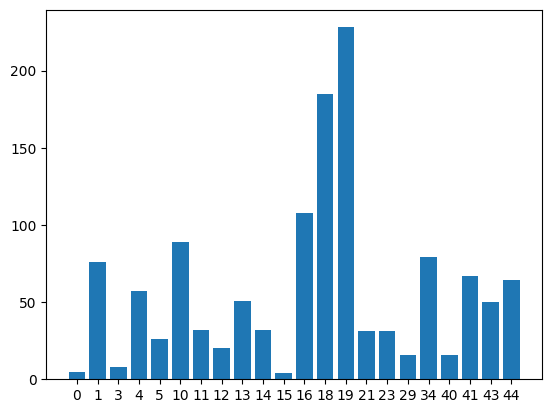

Top 10 Most Malignant Proportions: [0.2808988764044944, 0.29411764705882354, 0.3076923076923077, 0.3125, 0.3283582089552239, 0.34375, 0.35964912280701755, 0.3684210526315789, 0.4, 0.43037974683544306]
Top 10 Most Benign Proportions: [0.125, 0.125, 0.15625, 0.16129032258064516, 0.2, 0.21052631578947367, 0.22, 0.25, 0.25, 0.25806451612903225]
66.6% of one class 17 Proportion 0.7727272727272727
75% of one class 7 Proportion 0.3181818181818182
Benign cluster index: 16, Malignant cluster index: 17
Chosen cluster indices: [16, 17, 9, 19, 15, 12, 10, 4, 3, 18]
Most Benign Cluster


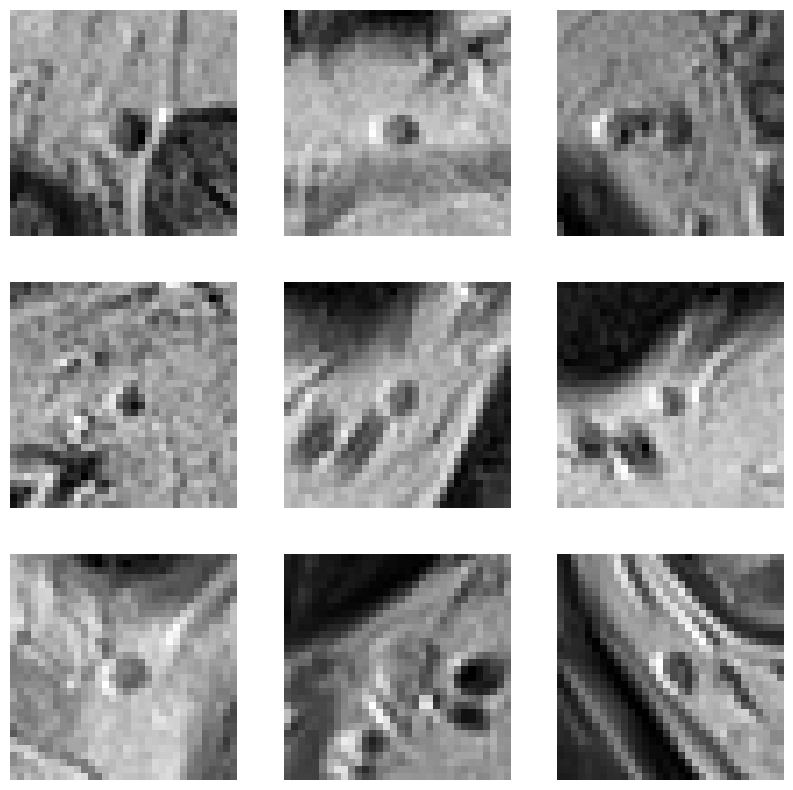

['\\mri//0043E1DC64_cbd772be8e_tra_sfov1_mri_0_1_9.nii', '\\mri//0043E1DC64_cbd772be8e_tra_sfov1_mri_0_6_21.nii', '\\mri//02A484B997_8ad077b1a7_tra_sfov_mri_3_4_18.nii', '\\mri//02A484B997_8ad077b1a7_tra_sfov_mri_3_5_26.nii', '\\mri//0378120061_5da76d5e3b_tra_sfov1_mri_4_12_18.nii', '\\mri//0378120061_5da76d5e3b_tra_sfov1_mri_4_15_21.nii', '\\mri//0378120061_5da76d5e3b_tra_sfov1_mri_4_5_13.nii', '\\mri//05E90318EE_1141e3099a_tra_sfov_mri_5_2_21.nii', '\\mri//05E90318EE_1141e3099a_tra_sfov_mri_5_5_13.nii']
Most Malignant Cluster


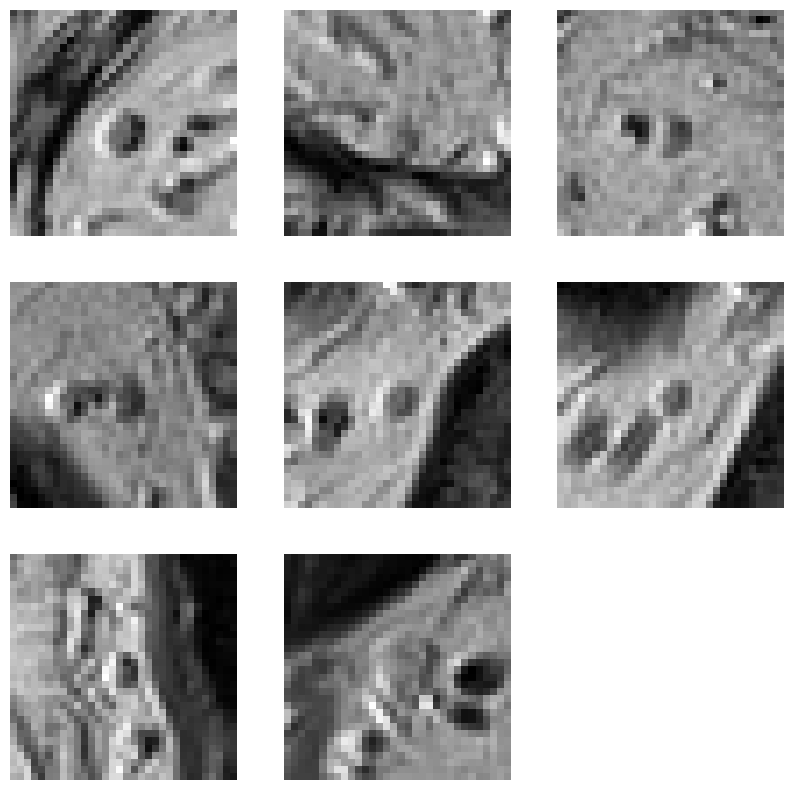

['\\mri//0043E1DC64_cbd772be8e_tra_sfov1_mri_0_5_18.nii', '\\mri//02A484B997_8ad077b1a7_tra_sfov_mri_3_1_15.nii', '\\mri//02A484B997_8ad077b1a7_tra_sfov_mri_3_2_20.nii', '\\mri//02A484B997_8ad077b1a7_tra_sfov_mri_3_4_18.nii', '\\mri//0378120061_5da76d5e3b_tra_sfov1_mri_4_11_17.nii', '\\mri//0378120061_5da76d5e3b_tra_sfov1_mri_4_12_18.nii', '\\mri//0378120061_5da76d5e3b_tra_sfov1_mri_4_13_18.nii', '\\mri//05E90318EE_1141e3099a_tra_sfov_mri_5_2_21.nii']
Example from Random Cluster 2


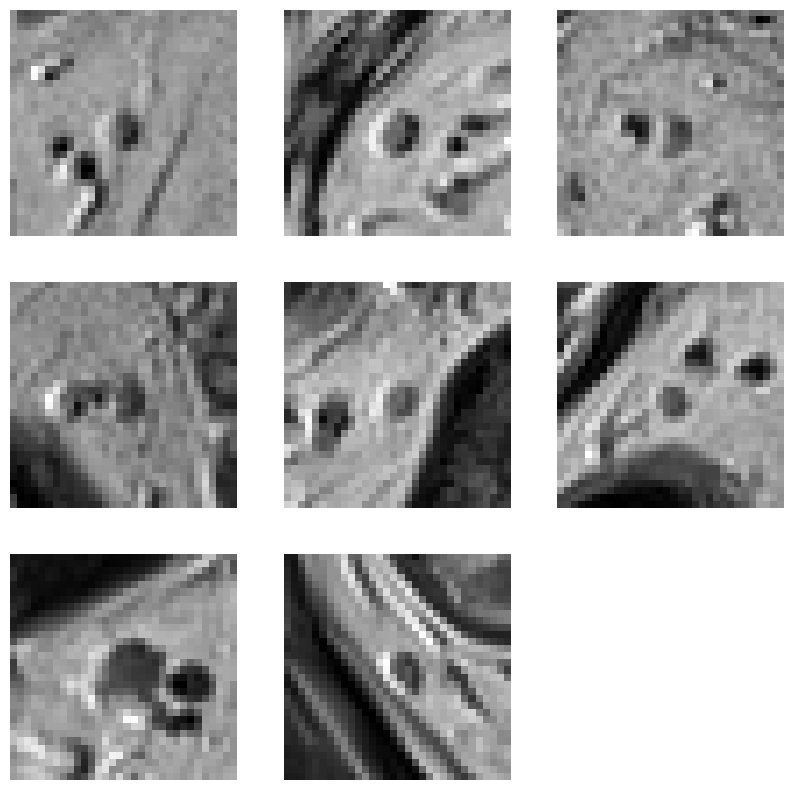

['\\mri//0043E1DC64_cbd772be8e_tra_sfov1_mri_0_4_16.nii', '\\mri//0043E1DC64_cbd772be8e_tra_sfov1_mri_0_5_18.nii', '\\mri//02A484B997_8ad077b1a7_tra_sfov_mri_3_2_20.nii', '\\mri//02A484B997_8ad077b1a7_tra_sfov_mri_3_4_18.nii', '\\mri//0378120061_5da76d5e3b_tra_sfov1_mri_4_11_17.nii', '\\mri//0378120061_5da76d5e3b_tra_sfov1_mri_4_9_15.nii', '\\mri//05E90318EE_1141e3099a_tra_sfov_mri_5_2_20.nii', '\\mri//05E90318EE_1141e3099a_tra_sfov_mri_5_5_13.nii']
Example from Random Cluster 3


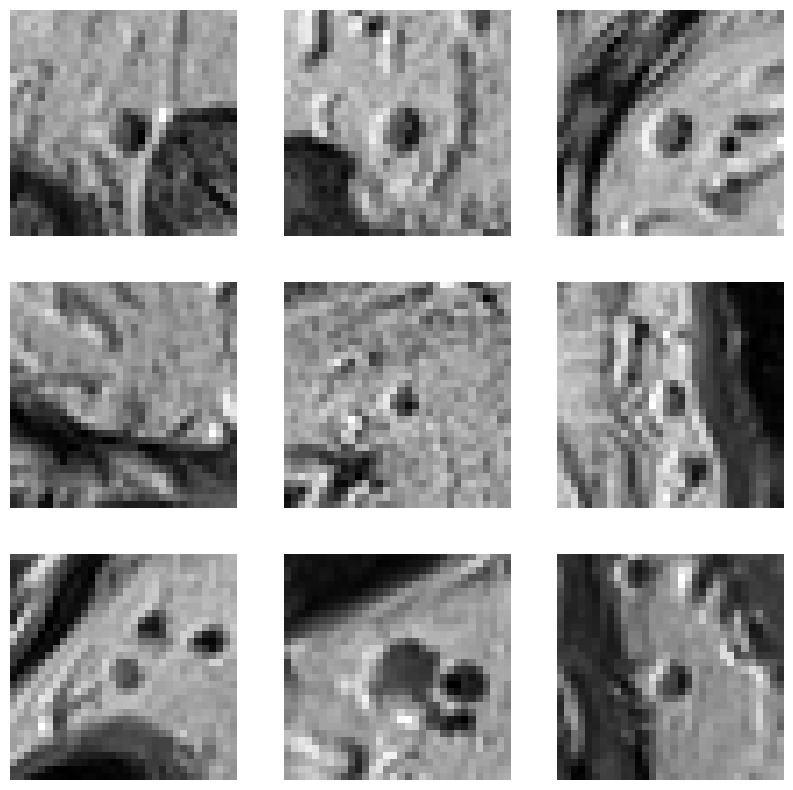

['\\mri//0043E1DC64_cbd772be8e_tra_sfov1_mri_0_1_9.nii', '\\mri//0043E1DC64_cbd772be8e_tra_sfov1_mri_0_2_12.nii', '\\mri//0043E1DC64_cbd772be8e_tra_sfov1_mri_0_5_18.nii', '\\mri//02A484B997_8ad077b1a7_tra_sfov_mri_3_1_15.nii', '\\mri//02A484B997_8ad077b1a7_tra_sfov_mri_3_5_26.nii', '\\mri//0378120061_5da76d5e3b_tra_sfov1_mri_4_13_18.nii', '\\mri//0378120061_5da76d5e3b_tra_sfov1_mri_4_9_15.nii', '\\mri//05E90318EE_1141e3099a_tra_sfov_mri_5_2_20.nii', '\\mri//05E90318EE_1141e3099a_tra_sfov_mri_5_4_18.nii']
Example from Random Cluster 4


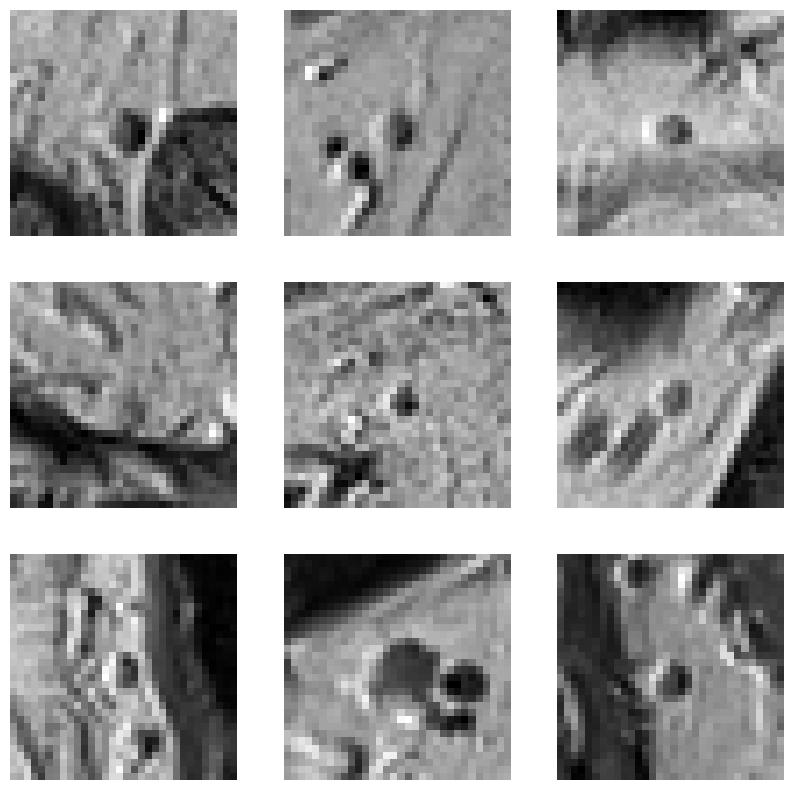

['\\mri//0043E1DC64_cbd772be8e_tra_sfov1_mri_0_1_9.nii', '\\mri//0043E1DC64_cbd772be8e_tra_sfov1_mri_0_4_16.nii', '\\mri//0043E1DC64_cbd772be8e_tra_sfov1_mri_0_6_21.nii', '\\mri//02A484B997_8ad077b1a7_tra_sfov_mri_3_1_15.nii', '\\mri//02A484B997_8ad077b1a7_tra_sfov_mri_3_5_26.nii', '\\mri//0378120061_5da76d5e3b_tra_sfov1_mri_4_12_18.nii', '\\mri//0378120061_5da76d5e3b_tra_sfov1_mri_4_13_18.nii', '\\mri//05E90318EE_1141e3099a_tra_sfov_mri_5_2_20.nii', '\\mri//05E90318EE_1141e3099a_tra_sfov_mri_5_4_18.nii']
Example from Random Cluster 5


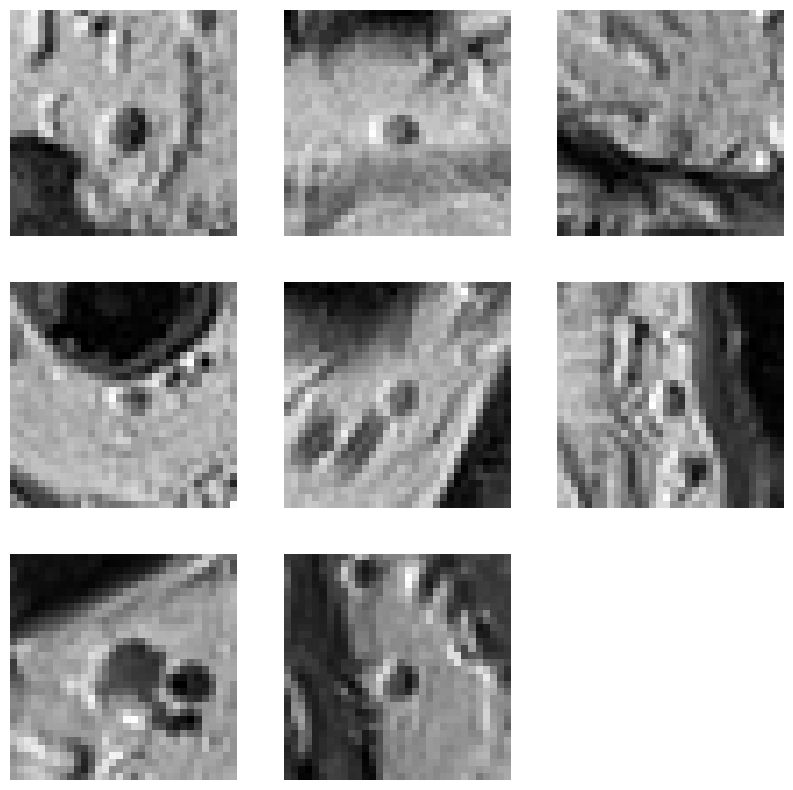

['\\mri//0043E1DC64_cbd772be8e_tra_sfov1_mri_0_2_12.nii', '\\mri//0043E1DC64_cbd772be8e_tra_sfov1_mri_0_6_21.nii', '\\mri//02A484B997_8ad077b1a7_tra_sfov_mri_3_1_15.nii', '\\mri//02A484B997_8ad077b1a7_tra_sfov_mri_3_3_20.nii', '\\mri//0378120061_5da76d5e3b_tra_sfov1_mri_4_12_18.nii', '\\mri//0378120061_5da76d5e3b_tra_sfov1_mri_4_13_18.nii', '\\mri//05E90318EE_1141e3099a_tra_sfov_mri_5_2_20.nii', '\\mri//05E90318EE_1141e3099a_tra_sfov_mri_5_4_18.nii']
Example from Random Cluster 6


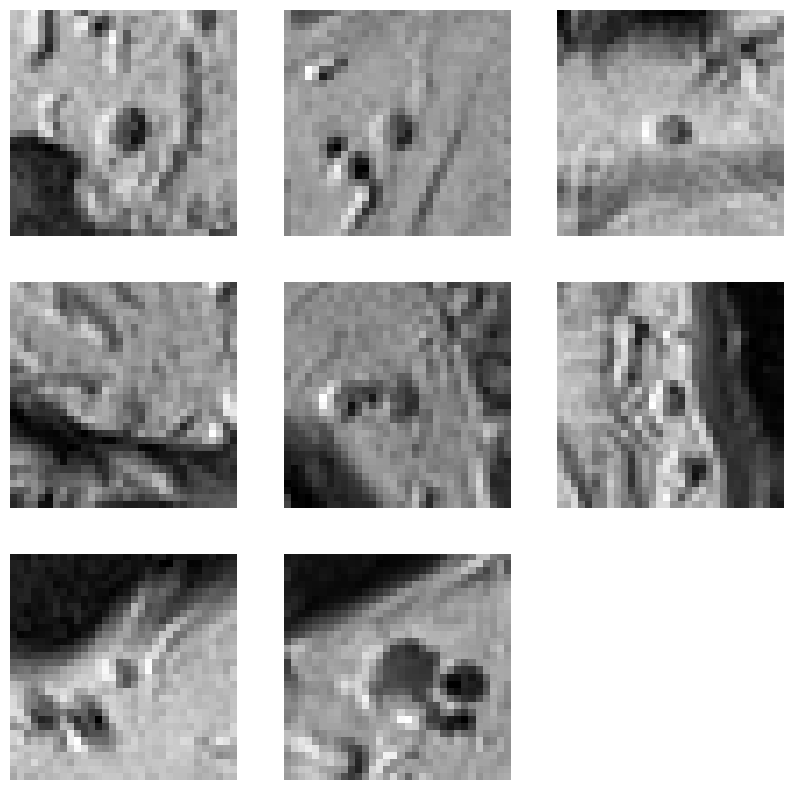

['\\mri//0043E1DC64_cbd772be8e_tra_sfov1_mri_0_2_12.nii', '\\mri//0043E1DC64_cbd772be8e_tra_sfov1_mri_0_4_16.nii', '\\mri//0043E1DC64_cbd772be8e_tra_sfov1_mri_0_6_21.nii', '\\mri//02A484B997_8ad077b1a7_tra_sfov_mri_3_1_15.nii', '\\mri//02A484B997_8ad077b1a7_tra_sfov_mri_3_4_18.nii', '\\mri//0378120061_5da76d5e3b_tra_sfov1_mri_4_13_18.nii', '\\mri//0378120061_5da76d5e3b_tra_sfov1_mri_4_15_21.nii', '\\mri//05E90318EE_1141e3099a_tra_sfov_mri_5_2_20.nii']
Example from Random Cluster 7


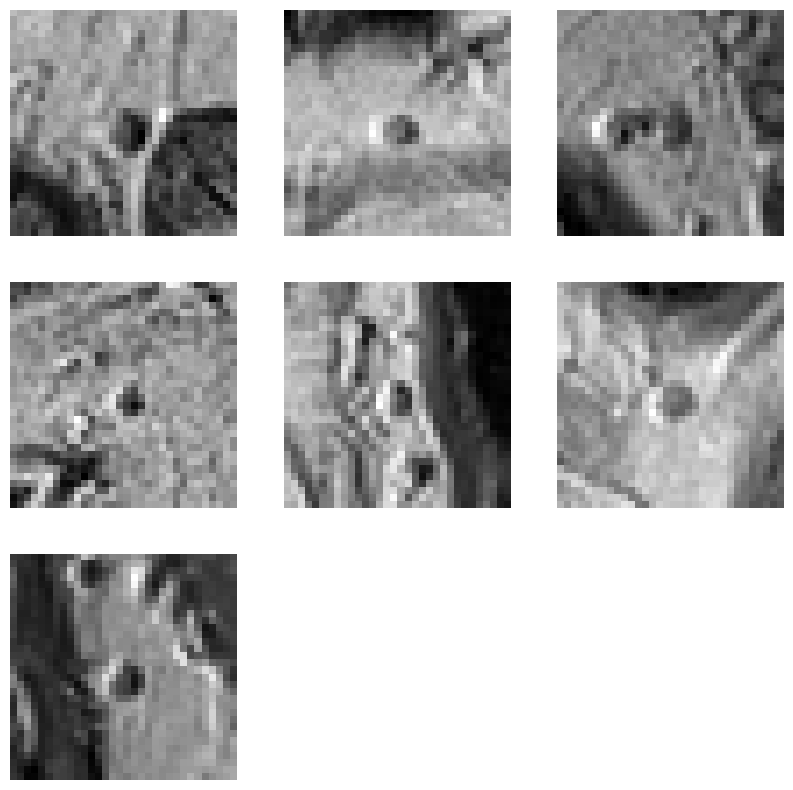

['\\mri//0043E1DC64_cbd772be8e_tra_sfov1_mri_0_1_9.nii', '\\mri//0043E1DC64_cbd772be8e_tra_sfov1_mri_0_6_21.nii', '\\mri//02A484B997_8ad077b1a7_tra_sfov_mri_3_4_18.nii', '\\mri//02A484B997_8ad077b1a7_tra_sfov_mri_3_5_26.nii', '\\mri//0378120061_5da76d5e3b_tra_sfov1_mri_4_13_18.nii', '\\mri//0378120061_5da76d5e3b_tra_sfov1_mri_4_5_13.nii', '\\mri//05E90318EE_1141e3099a_tra_sfov_mri_5_4_18.nii']
Example from Random Cluster 8


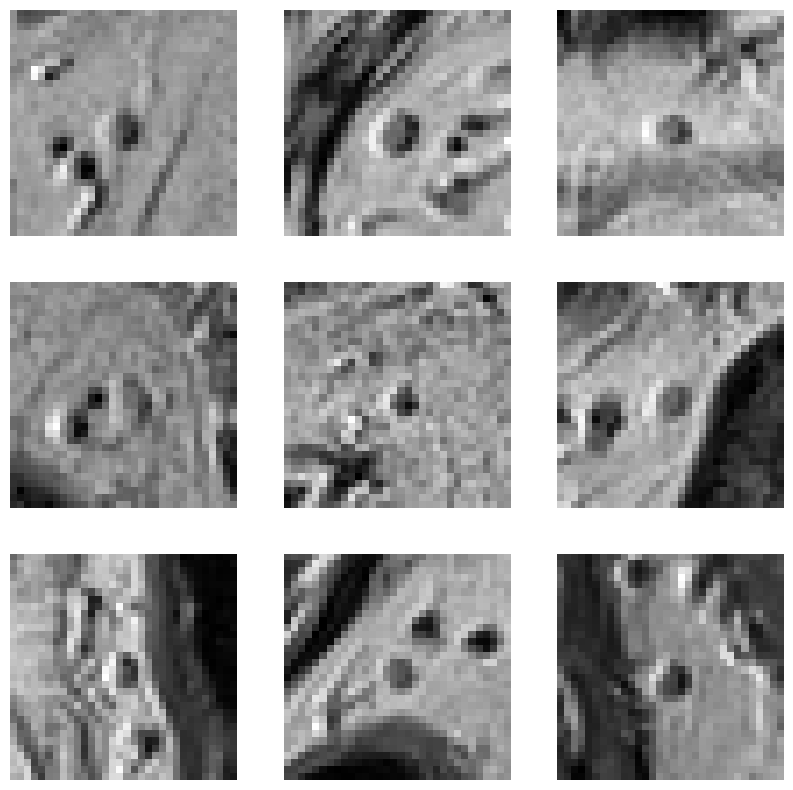

['\\mri//0043E1DC64_cbd772be8e_tra_sfov1_mri_0_4_16.nii', '\\mri//0043E1DC64_cbd772be8e_tra_sfov1_mri_0_5_18.nii', '\\mri//0043E1DC64_cbd772be8e_tra_sfov1_mri_0_6_21.nii', '\\mri//02A484B997_8ad077b1a7_tra_sfov_mri_3_4_19.nii', '\\mri//02A484B997_8ad077b1a7_tra_sfov_mri_3_5_26.nii', '\\mri//0378120061_5da76d5e3b_tra_sfov1_mri_4_11_17.nii', '\\mri//0378120061_5da76d5e3b_tra_sfov1_mri_4_13_18.nii', '\\mri//0378120061_5da76d5e3b_tra_sfov1_mri_4_9_15.nii', '\\mri//05E90318EE_1141e3099a_tra_sfov_mri_5_4_18.nii']
Example from Random Cluster 9


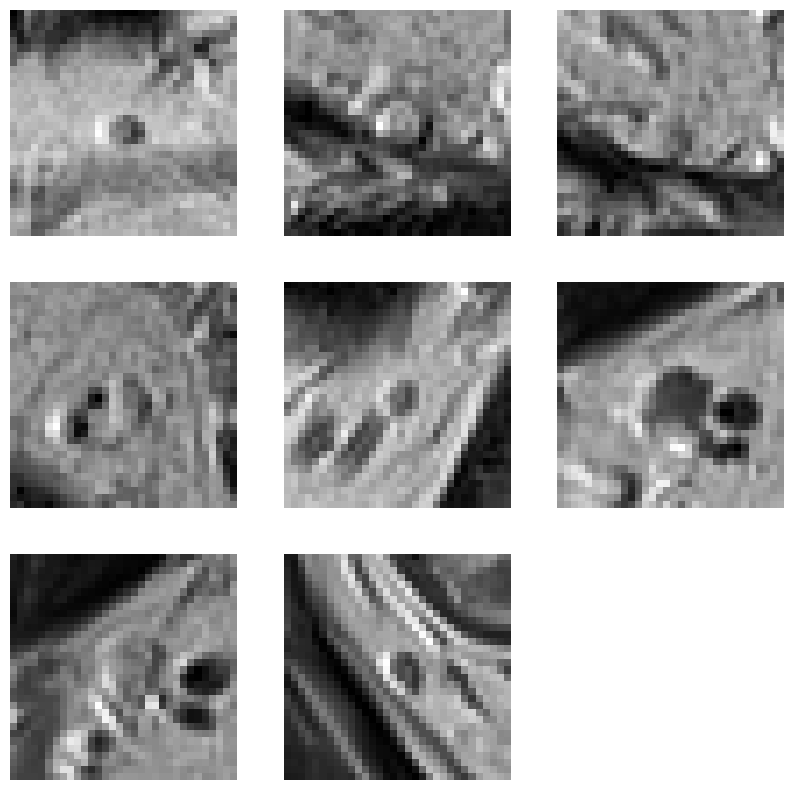

['\\mri//0043E1DC64_cbd772be8e_tra_sfov1_mri_0_6_21.nii', '\\mri//02A484B997_8ad077b1a7_tra_sfov_mri_3_1_14.nii', '\\mri//02A484B997_8ad077b1a7_tra_sfov_mri_3_1_15.nii', '\\mri//02A484B997_8ad077b1a7_tra_sfov_mri_3_4_19.nii', '\\mri//0378120061_5da76d5e3b_tra_sfov1_mri_4_12_18.nii', '\\mri//05E90318EE_1141e3099a_tra_sfov_mri_5_2_20.nii', '\\mri//05E90318EE_1141e3099a_tra_sfov_mri_5_2_21.nii', '\\mri//05E90318EE_1141e3099a_tra_sfov_mri_5_5_13.nii']


In [58]:
kmeans = KMeans(n_clusters=45)
kmeans.fit(latent_vectors)
kmeans_dict = {i: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}
# remove keys if less than 5 items
kmeans_dict = {k: v for k, v in kmeans_dict.items() if len(v) > 3}
print('Number of clusters more than 1', len(kmeans_dict))

print('mean and standard deviation of cluster sizes:', np.mean([len(v) for v in kmeans_dict.values()]), np.std([len(v) for v in kmeans_dict.values()]))

short_std, long_std, ratio_std, BI_std, min_short_std, max_short_std, min_long_std, max_long_std, min_ratio_std, max_ratio_std, min_BI_std, max_BI_std, min_range, max_range, mean_range = calculate_cluster_statistics(kmeans_dict, df)
print('min BI', min_BI_std, 'max BI', max_BI_std, 'min range', min_range, 'max range', max_range, 'mean range', mean_range)
cluster_sizes(kmeans_dict)
#patient_proportions(kmeans_dict, df)
plot_cluster_distribution(kmeans_dict)
proportions = get_malignant_proportions(kmeans_dict, df, 1)
malignancy_proportion_stats(proportions)

print_random_cluster_sample(kmeans_dict, "kmeans_gaussian", proportions, df)

### Grid Search for K-means cluster sizes aiming to have the lowest short-axis diameter standard deviation within clusters (to minimise LN size variability in the clusters)

In [ ]:
best_short_std = 3
best_ssim = 0.08
best_cluster_stats = []

for n in range(25, 80):
    print("number of clusters", n)
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(latent_vectors)
    kmeans_dict = {i: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}
    kmeans_dict = {k: v for k, v in kmeans_dict.items() if len(v) > 3}
    print('Number of clusters more than 1', len(kmeans_dict))

    short_std, long_std, ratio_std, BI_std, min_short_std, max_short_std, min_long_std, max_long_std, min_ratio_std, max_ratio_std, min_BI_std, max_BI_std, min_range, max_range, mean_range = calculate_cluster_statistics(kmeans_dict, df)
    average_ssim = calculate_average_ssim(kmeans_dict, df)
    #if short_std < best_short_std:
    if average_ssim > best_ssim:
        print('new best ssim', average_ssim, 'old best ssim', best_ssim)
        best_short_std = short_std
        best_ssim = average_ssim
        best_clusters = n
        best_cluster_stats  = ["short std", short_std, "long std", long_std, "ratio std", ratio_std, "BI std", BI_std, "Min short", min_short_std, "Max short", max_short_std, "Min long", min_long_std, "Max long", max_long_std, "Min ratio", min_ratio_std, "Max ratio", max_ratio_std, "Min BI", min_BI_std, "Max BI", max_BI_std, "Min range", min_range, "Max range", max_range, "mean range", mean_range, "average ssim", average_ssim]
        print("best clusters", best_clusters, "stats", best_cluster_stats)

print("best clusters", best_clusters, "short std", min_short_std, "stats", best_cluster_stats)


Long Axis Statistics:
  Mean Long Axis=8.41, Median Long Axis=8.25, Std Dev Long Axis=0.83, inter cluster std dev=2.82
best clusters 65 short std 0.8597553592837068 stats ['short std', 1.8154147967312466, 'long std', 2.5225689313002517, 'ratio std', 0.11909593095619944, 'BI std', 0.11825075079048193, 'Min short', 0.6961559642355433, 'Max short', 3.222727935256235, 'Min long', 1.281931046304645, 'Max long', 4.205943426518974, 'Min ratio', 0.06801377132957905, 'Max ratio', 0.33407717920022206, 'Min BI', 0.5981907625900637, 'Max BI', 0.9119197804005982, 'Min range', [1.7172703146077515, 3.022474987245606, 0.16912501868921292, 0.09309607464850198], 'Max range', [12.721416253205408, 15.928521524622429, 0.8111740922694047, 0.6783414002780799], 'mean range', [7.289775719109587, 9.61612006666593, 0.43060365567590375, 0.3464635515591438]]

In [ ]:
def calculate_average_ssim_random_sample(df, n_samples=500, verbose=True):
    """
    Calculate the average SSIM between 100 random files sampled from the entire dataset.

    Args:
        df (pd.DataFrame): The DataFrame containing image file names and metadata.
        n_samples (int): The number of random files to sample from the dataset.
        verbose (bool): Whether to print the SSIM statistics.

    Returns:
        float: The average SSIM across the sampled files.
    """
    file_root = r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1_2D_slices"

    # Randomly sample 100 files from the dataset
    sampled_files = df['file'].sample(n=min(n_samples, len(df)), random_state=42).values

    # Load the sampled images
    images = []
    for file_name in sampled_files:
        # Load .nii file and extract the image data
        img = nib.load(file_root + file_name).get_fdata()
        # Normalize the image to [0, 1] and convert to numpy
        img = (img - img.min()) / (img.max() - img.min())
        img = np.squeeze(img)
        images.append(img)
    print(len(images))

    # Calculate SSIM for each pair of images
    ssim_values = []
    for img1, img2 in combinations(images, 2):
        ssim_score = ssim(img1,img2, data_range=img1.max() - img1.min()
        )
        ssim_values.append(ssim_score.item())  # Extract the float value

    # Compute average SSIM
    average_ssim = sum(ssim_values) / len(ssim_values) if ssim_values else 0.0

    if verbose:
        print(f"Average SSIM across {n_samples} random files: {average_ssim:.4f}")
        print(f"Min SSIM: {min(ssim_values):.4f}, Max SSIM: {max(ssim_values):.4f}")

    return average_ssim
calculate_average_ssim_random_sample(df, n_samples=200, verbose=True)

### Average over 10 runs for each choice in grid search

In [ ]:
avg_results = {"short std": {}, "long_std": {}, "ratio_std": {}, "BI_std": {}, "min_short_std": {}, "max_short_std": {}, "min_long_std": {}, "max_long_std": {}, "min_ratio_std": {}, "max_ratio_std": {}, "min_BI_std": {}, "max_BI_std": {}, "min_range": {}, "max_range": {}, "mean_range": {}, "num_clusters": {}}
best_result = {"short std": 3}
for k in range(50, 100):
    short_std_list, long_std_list, ratio_std_list, BI_std_list, min_short_std_list, max_short_std_list, min_long_std_list, max_long_std_list, min_ratio_std_list, max_ratio_std_list, min_BI_std_list, max_BI_std_list, min_range_list, max_range_list, mean_range_list, num_clusters_list = [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []
    for i in range(10):
        #print("number of clusters", k)
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(latent_vectors)
        kmeans_dict = {i: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}
        kmeans_dict = {k: v for k, v in kmeans_dict.items() if len(v) > 3}
        #print('Number of clusters more than 1', len(kmeans_dict))
        num_clusters_list.append(len(kmeans_dict))
    
        short_std, long_std, ratio_std, BI_std, min_short_std, max_short_std, min_long_std, max_long_std, min_ratio_std, max_ratio_std, min_BI_std, max_BI_std, min_range, max_range, mean_range = calculate_cluster_statistics(kmeans_dict, df, verbose=False)
        short_std_list.append(short_std)
        long_std_list.append(long_std)
        ratio_std_list.append(ratio_std)
        BI_std_list.append(BI_std)
        min_short_std_list.append(min_short_std)
        max_short_std_list.append(max_short_std)
        min_long_std_list.append(min_long_std)
        max_long_std_list.append(max_long_std)
        min_ratio_std_list.append(min_ratio_std)
        max_ratio_std_list.append(max_ratio_std)
        min_BI_std_list.append(min_BI_std)
        max_BI_std_list.append(max_BI_std)
        min_range_list.append(min_range)
        max_range_list.append(max_range)
        mean_range_list.append(mean_range)
    avg_results["short std"][k] = [np.mean(short_std_list), np.std(short_std_list)]
    avg_results["long_std"][k] = [np.mean(long_std_list), np.std(long_std_list)]
    avg_results["ratio_std"][k] = [np.mean(ratio_std_list), np.std(ratio_std_list)]
    avg_results["BI_std"][k] = [np.mean(BI_std_list), np.std(BI_std_list)]
    avg_results["min_short_std"][k] = [np.mean(min_short_std_list), np.std(min_short_std_list)]
    avg_results["max_short_std"][k] = [np.mean(max_short_std_list), np.std(max_short_std_list)]
    avg_results["min_long_std"][k] = [np.mean(min_long_std_list), np.std(min_long_std_list)]
    avg_results["max_long_std"][k] = [np.mean(max_long_std_list), np.std(max_long_std_list)]
    avg_results["min_ratio_std"][k] = [np.mean(min_ratio_std_list), np.std(min_ratio_std_list)]
    avg_results["max_ratio_std"][k] = [np.mean(max_ratio_std_list), np.std(max_ratio_std_list)]
    avg_results["min_BI_std"][k] = [np.mean(min_BI_std_list), np.std(min_BI_std_list)]
    avg_results["max_BI_std"][k] = [np.mean(max_BI_std_list), np.std(max_BI_std_list)]
    avg_results["min_range"][k] = [np.mean(min_range_list), np.std(min_range_list)]
    avg_results["max_range"][k] = [np.mean(max_range_list), np.std(max_range_list)]
    avg_results["mean_range"][k] = [np.mean(mean_range_list), np.std(mean_range_list)]
    avg_results["num_clusters"][k] = [np.mean(num_clusters_list), np.std(num_clusters_list)]
    print("Number of clusters", k, "short std", np.mean(short_std_list), np.std(short_std_list), "long std", np.mean(long_std_list), np.std(long_std_list), "ratio std", np.mean(ratio_std_list), np.std(ratio_std_list), "BI std", np.mean(BI_std_list), np.std(BI_std_list))
    
    if np.mean(short_std_list) < best_result["short std"]:
        best_result["short std"] = np.mean(short_std_list)
        best_result["long std"] = np.mean(long_std_list)
        best_result["ratio std"] = np.mean(ratio_std_list)
        best_result["BI std"] = np.mean(BI_std_list)
        best_result["min short std"] = np.mean(min_short_std_list)
        best_result["max short std"] = np.mean(max_short_std_list)
        best_result["min long std"] = np.mean(min_long_std_list)
        best_result["max long std"] = np.mean(max_long_std_list)
        best_result["min ratio std"] = np.mean(min_ratio_std_list)
        best_result["max ratio std"] = np.mean(max_ratio_std_list)
        best_result["min BI std"] = np.mean(min_BI_std_list)
        best_result["max BI std"] = np.mean(max_BI_std_list)
        best_result["min range"] = np.mean(min_range_list)
        best_result["max range"] = np.mean(max_range_list)
        best_result["mean range"] = np.mean(mean_range_list)
        best_result["clusters"] = k
        best_result["num big clusters"] = np.mean(num_clusters_list)
        print("best result", best_result)

# lowest short std
print("best result", best_result)

# best result {'short std': 2.050519292205215, 'long std': 2.7064741193171202, 'ratio std': 0.11090981811536478, 'BI std': 0.12765436474810848, 'min short std': 0.6816644158012106, 'max short std': 3.3502920789466337, 'min long std': 1.2140250726742665, 'max long std': 4.272171537422949, 'min ratio std': 0.03174494829210546, 'max ratio std': 0.2033167516267711, 'min BI std': 0.06182350845203247, 'max BI std': 0.2229768020621797, 'min range': 1.2557270464759935, 'max range': 7.443638510942124, 'mean range': 4.682786352008556, 'clusters': 99, 'num big clusters': 33.6}

### Exploratory analysis

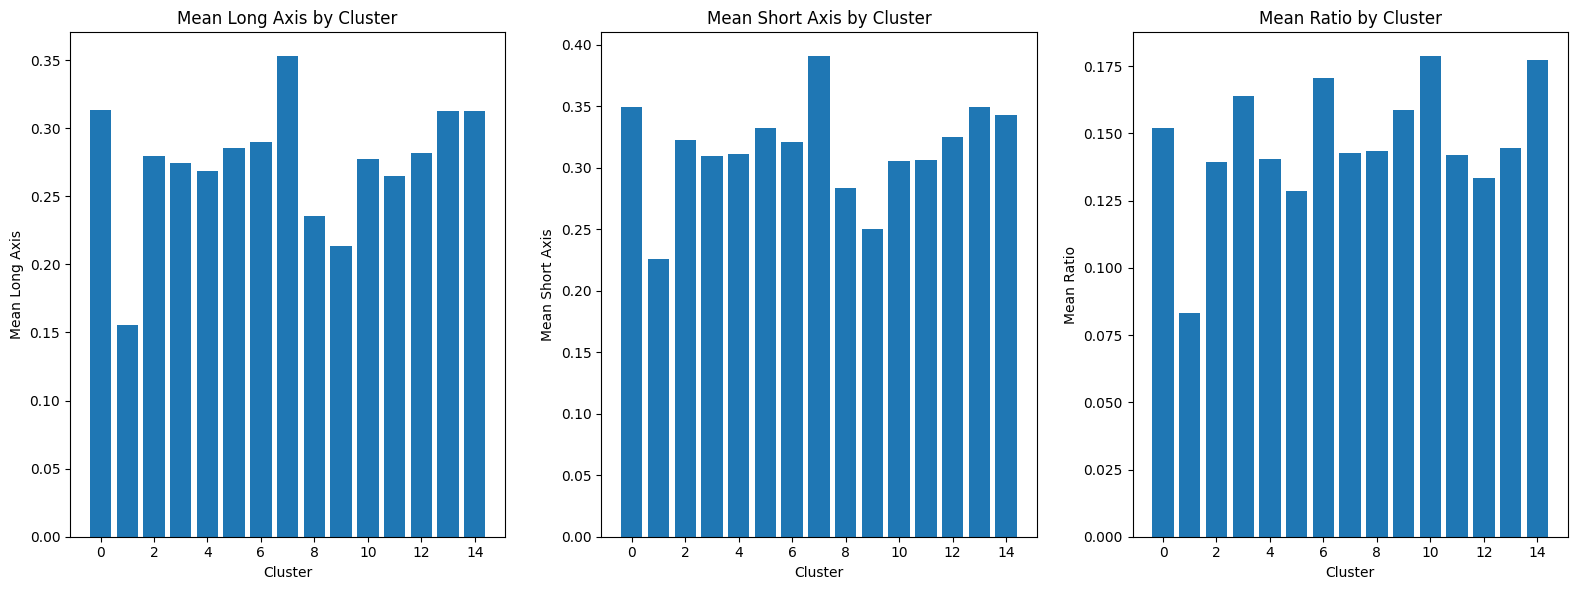

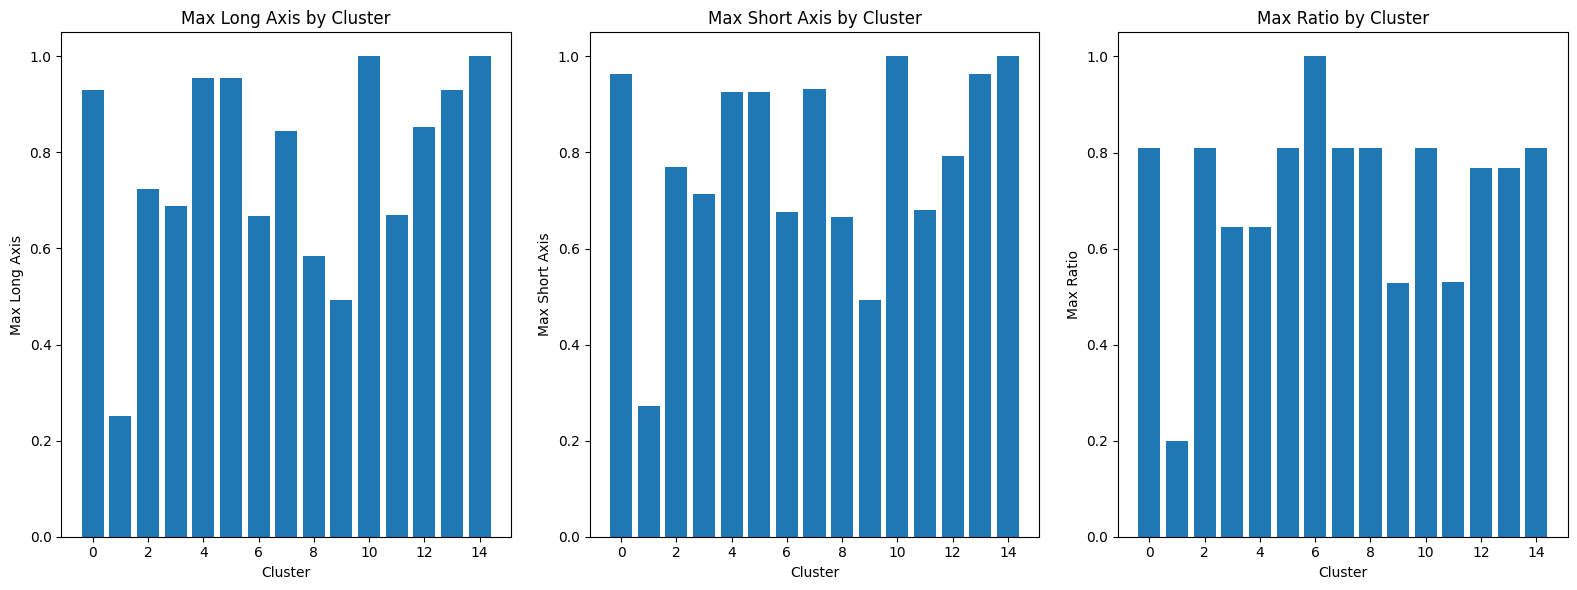

In [27]:
LA, SA, R = [], [], []
LA_max, SA_max, R_max = [], [], []
for cluster in kmeans_dict:
    LA.append(df.loc[kmeans_dict[cluster]]['long_axis'].mean())
    SA.append(df.loc[kmeans_dict[cluster]]['short_axis'].mean())
    R.append(df.loc[kmeans_dict[cluster]]['ratio'].mean())
    LA_max.append(df.loc[kmeans_dict[cluster]]['long_axis'].max())
    SA_max.append(df.loc[kmeans_dict[cluster]]['short_axis'].max())
    R_max.append(df.loc[kmeans_dict[cluster]]['ratio'].max())
    

n=15
# bar charts
fig, ax = plt.subplots(1, 3, figsize=(16, 6))
ax[0].bar(range(n), LA)
ax[0].set_title('Mean Long Axis by Cluster')
ax[0].set_xlabel('Cluster')
ax[0].set_ylabel('Mean Long Axis')
ax[1].bar(range(n), SA)
ax[1].set_title('Mean Short Axis by Cluster')
ax[1].set_xlabel('Cluster')
ax[1].set_ylabel('Mean Short Axis')
ax[2].bar(range(n), R)
ax[2].set_title('Mean Ratio by Cluster')
ax[2].set_xlabel('Cluster')
ax[2].set_ylabel('Mean Ratio')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(16, 6))
ax[0].bar(range(n), LA_max)
ax[0].set_title('Max Long Axis by Cluster')
ax[0].set_xlabel('Cluster')
ax[0].set_ylabel('Max Long Axis')
ax[1].bar(range(n), SA_max)
ax[1].set_title('Max Short Axis by Cluster')
ax[1].set_xlabel('Cluster')
ax[1].set_ylabel('Max Short Axis')
ax[2].bar(range(n), R_max)
ax[2].set_title('Max Ratio by Cluster')
ax[2].set_xlabel('Cluster')
ax[2].set_ylabel('Max Ratio')
plt.tight_layout()
plt.show()



PCA done! Time elapsed: 0.013075100257992744 seconds


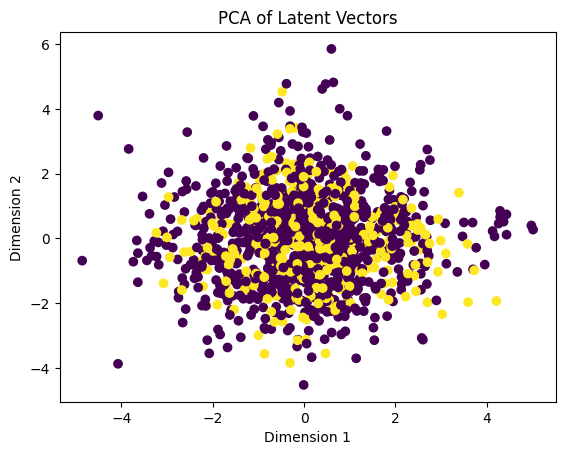

In [20]:
time_start = perf_counter()
pca = PCA(n_components=2)
principal_component = pca.fit_transform(latent_vectors)
time_stop= perf_counter()

print('PCA done! Time elapsed: {} seconds'.format(time_stop-time_start))
x = [com[0] for com in principal_component]
y = [com[1] for com in principal_component]
plt.scatter(x, y, c=labels, cmap='viridis')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('PCA of Latent Vectors')
plt.show()
plt.close()

t-SNE done! Time elapsed: 2.1489368001930416 seconds


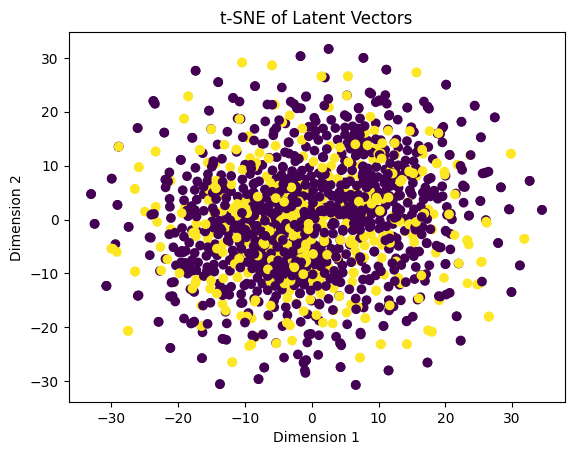

In [19]:
time_start = perf_counter()
tsne_images = TSNE(perplexity=10,learning_rate=8).fit_transform(latent_vectors)
time_stop= perf_counter()

print('t-SNE done! Time elapsed: {} seconds'.format(time_stop-time_start))
x = [tsne[0] for tsne in tsne_images]
y = [tsne[1] for tsne in tsne_images]
plt.scatter(x, y, c=labels, cmap='viridis')
#plt.scatter(x,y, c=labels, label=labels)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE of Latent Vectors')
plt.show()
plt.close()

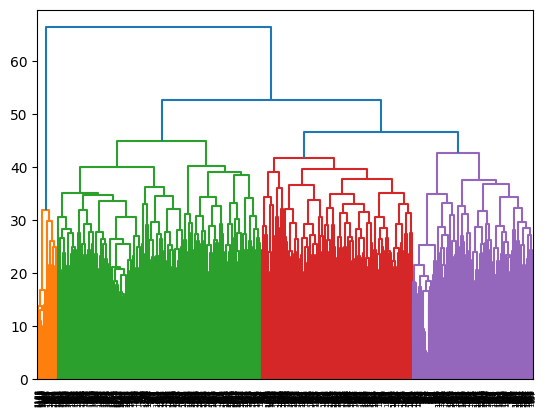

In [5]:
dendrogram = sch.dendrogram(sch.linkage(latent_vectors, method='ward'))